Import functions 

In [121]:
#%matplotlib widget
import pycbc
from pycbc import waveform, conversions, filter, types, distributions, detector, psd
import matplotlib.pyplot as plt
import numpy as np
import mass as mass
import functions as func
import injections as inj
import scipy
import seaborn as sns
import importlib
from random import randrange
import time
import h5py
import matplotlib.gridspec as gridspec
from scipy.interpolate import griddata
import lal
lal.ClobberDebugLevel(0)

#plt.rcParams.update({
#    "text.usetex": True})
importlib.reload(func)
importlib.reload(inj)

<module 'injections' from '/work/rahul.dhurkunde/HM_and_precession/libraries/injections.py'>

Read the Template Bank and initialize some variables

In [123]:
delta_f = 1/32
delta_t = 1.0/4096
f_min  = 30.0

#tb1 = func.read_tb("banks/parallel/aligned_bank/combined_bank.hdf", f_min)
tb1 = func.read_tb("banks/parallel/smallbank/combined_bank.hdf", f_min)
#func.get_mass_ranges_from_TB(tb)
print(conversions.tau0_from_mass1_mass2(5.0, 1.0, 10.0), len(tb1))

Template bank -- banks/parallel/smallbank/combined_bank.hdf
506.59578355182947 1128


Read injections from a file

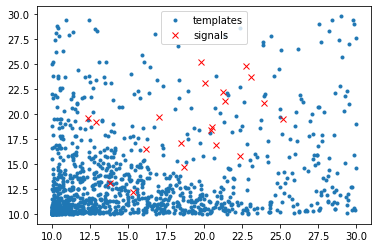

No of signals 20


In [109]:
nsignal = 20
approximant_sg = 'IMRPhenomD'
approximant_tb1 = 'IMRPhenomD'
HMs = False     #Only for signals as of now

sg = []
for k in range(1):
    filename = 'injections/testing/%s.hdf' %k
    sg = sg + inj.read_injections_HDF(filename, nsignal, f_min)
    
tb1_m1 = [x.m1 for x in tb1]
tb1_m2 = [x.m2 for x in tb1]
plt.plot(tb1_m1, tb1_m2, '.', label='templates')
sg_m1 = [x.m1 for x in sg]
sg_m2 = [x.m2 for x in sg]
plt.plot(sg_m1, sg_m2, 'x', color='red', label = 'signals')
plt.legend()
plt.show()
print('No of signals', len(sg))

Exec time 127.45858550071716


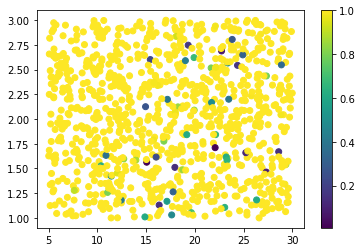

In [668]:
start = time.time()
dot_products = func.real_imag_dot_product(sg, PSD, f_min, delta_f, approximant_sg, nsignal)
end = time.time()
print('Exec time', end-start)
#xi = np.linspace(min(sg_m1),max(sg_m1),100)
#yi = np.linspace(min(sg_m2),max(sg_m2),100)
#zi = griddata((sg_m1, sg_m2), dot_products, (xi[None,:], yi[:,None]), method='linear')
#plt.pcolormesh(xi, yi, zi)
fig3, ax3 = plt.subplots() 
#im = plt.tricontourf(sg_m1, sg_m2, dot_products)
im3 = plt.scatter(sg_m1, sg_m2, c = dot_products)
#print(dot_products)
fig3.colorbar(im3)
plt.savefig('hplus_hcross.png', dpi=600)

Tau distributions

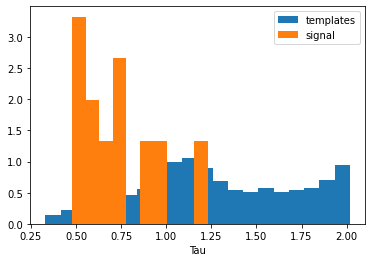

Extreme taus of templates 0.3308992844771706 2.0173055902573775
Extreme taus of signal 0.4779121704537993 1.229234034370664


In [78]:
sg_tau = np.array([x.tau0 for x in sg])
tb_tau = np.array([x.tau0 for x in tb1])
plt.hist(tb_tau, density = True, bins = 20, label = 'templates')
plt.hist(sg_tau, density = True, label = 'signal')
plt.xlabel('Tau')
plt.legend()
plt.show()
print('Extreme taus of templates', min(tb_tau), max(tb_tau))
print('Extreme taus of signal', min(sg_tau), max(sg_tau))

Read FULL bank matches from files

Max tau difference 0.17983150417470206


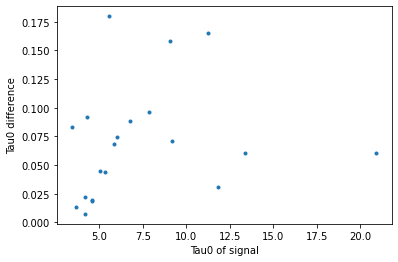

In [626]:
best_template = []
ff_array = []
tau_diff = []
sg_tau0 = []
for i in range(nsignal):
    filename = 'matches/full_matches/TF2_%s.hdf' %i
    hf = h5py.File(filename, 'r')
    matches = np.array(hf['match'])
    t_indices = np.array(hf['t_ind'])
    max_ind = np.argmax(matches)
    ff_array.append(matches[max_ind])
    best_template.append(tb[t_indices[max_ind]].tau0)
    tau_diff.append(abs(sg[i].tau0 - best_template[i]))
    sg_tau0.append(sg[i].tau0)
    
plt.plot(sg_tau0, tau_diff, '.')
plt.xlabel('Tau0 of signal')
plt.ylabel('Tau0 difference')
print('Max tau difference', max(tau_diff))
nbins_tau_threshold = 50    #about 0.25 times ninjections 
#tau_func = func.compute_tauThreshold_envelope(sg_tau0, tau_diff, nbins_tau_threshold)
tau_func = func.flat_tau_envelope(1.5, 100.0, nbins_tau_threshold)

Compute match with the templates having a tau0 mismatch (w.r.t signal) within a tolerance  

In [110]:
detect = detector.Detector('H1')
tau0_threshold = 0.5
signal_matches = []
length = int(1.0/(delta_f*delta_t*2)) + 1
PSD = psd.analytical.aLIGOZeroDetHighPower(length, delta_f, f_min)

diff_match_ff = []
tau_diff = []
recovered_tau0 = []
start = time.time()
for n in range(nsignal):
    #Check for tau0 of templates
    #n = 17
    temp_indices = func.check_tau0_for_template_generation(tb1, sg[n], tau0_threshold)
    matches = func.compute_match(tb1, sg[n], PSD, temp_indices, delta_f, f_min, detect, approximant_tb1, approximant_sg, HMs)
    signal_matches.append(np.max(matches))
    recovered_tau0.append(tb1[temp_indices[np.argmax(matches)]].tau0)    
    
    #filename = 'matches/full_matches/TF2_%i.hdf' %n
    #func.save_matches_HDF(matches, temp_indices, filename)
   
    if (n%1==0):
        end = time.time()
        #print(n, len(tb1), len(temp_indices), 'Execution time = ', end - start)
        print(signal_matches[n])
        start = time.time()
    #print('Execution time = ', end - start, 'no.of templates', len(temp_indices))
#print(signal_matches)    

RuntimeError: Invalid argument

Compare the FF after introducing a tau-threshold

Scatter plot with colors indicating the match values

0.8405357904497123


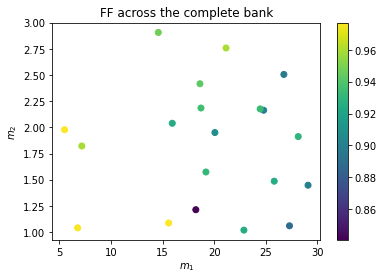

In [624]:
fig1, ax1 = plt.subplots()

sg_m1 = [x.m1 for x in sg]
sg_m2 = [x.m2 for x in sg]    
#im = plt.tricontourf(sg_m1, sg_m2, signal_matches)
im = plt.scatter(sg_m1, sg_m2, c = signal_matches)
#plt.plot(sg_m1, sg_m2, 'x', color='red')
fig1.colorbar(im)
plt.xlabel('$m_1$')
plt.ylabel('$m_2$')
plt.title('FF across the complete bank')
plt.savefig('plots/ff_complete_bank_50.png', dpi = 600)
print(min(signal_matches))

0.9991977337028988


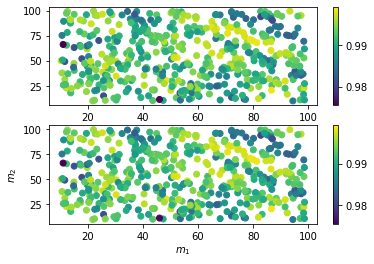

In [365]:
axes = gridspec.GridSpec(2,1)
plt.figure()

sg_m1 = [x.m1 for x in sg]
sg_m2 = [x.m2 for x in sg]    


ax1 = plt.subplot(axes[0,0])
im1 = plt.scatter(sg_m1, sg_m2, c = signal_matches)
plt.colorbar(im1)

ax2 = plt.subplot(axes[1,0])
im2 = plt.scatter(sg_m1, sg_m2, c = ff_array)
plt.colorbar(im2)
plt.xlabel('$m_1$')
plt.ylabel('$m_2$')
print(max(signal_matches))

Distribution of match across the template (tau0)

In [ ]:
tb_taus = np.array([x.tau0 for x in tb])
yolo = []
for i in range(nsignal):
    yolo.append(np.abs(ff_array[i] - signal_matches[i]))
#plt.plot(tb_taus, match_array[1], '.')
#plt.plot(tb_taus[np.argmax(match_array[0])], np.max(match_array[0]), 'x', color = 'red', label = 'Best match')
plt.scatter(sg_tau0, yolo)
plt.xlabel('Tau0')
plt.ylabel('Match')
plt.title('Match of a single signal with every template')
#plt.legend()

50 51


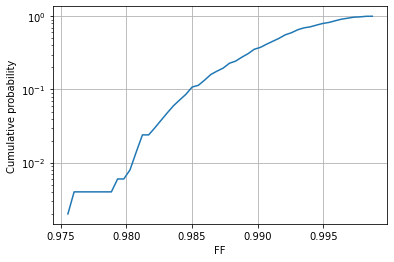

In [367]:
n, bins = np.histogram(signal_matches, density = True, bins=50)
cumulative = np.cumsum(n)*(bins[1]-bins[0])
print(len(cumulative), len(bins))
plt.yscale('log')
plt.plot(bins[:-1], cumulative)
plt.xlabel('FF')
plt.ylabel('Cumulative probability')
plt.grid()
plt.show()